# Internal Tide (only), 1 simulation

To adjust:

- double stratification
- change vertical shape of the profile such that limiting shape is that of a mode 1
- output itide_deltay parameter (forcing y width)
- forcing_itide -> itide_forcing ?
- add 1km simulations

Variable important is `un_std`, `N2` (evolution)

Mode 5 is not well represented with 4km resolution.

watch out sensitity to horizontal width of the itide forcing: it may be comparable to iwave wavelength for high modes

see link to [forcing description](../configs/itbalt/readme.ipynb)

In [2]:
from glob import glob
import itertools

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt
import crocosi.vmodes as vmd

In [2]:
from dask.distributed import Client, LocalCluster

if True:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:44237,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:39510,Total threads: 7
Dashboard: http://127.0.0.1:60768/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:36296,


## Load data

In [40]:
# paths
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
root_path = '/home1/scratch/slgentil/' 

T, D = [1,2,3], [4,2]
runs = ['fsturb_t{}_r0_a4_{}km_0a50j'.format(t,d) for t, d in itertools.product(T, D)]
TD = list(itertools.product(T, D))

_ = [print(r) for r in runs]

fsturb_t1_r0_a4_4km_0a50j
fsturb_t1_r0_a4_2km_0a50j
fsturb_t2_r0_a4_4km_0a50j
fsturb_t2_r0_a4_2km_0a50j
fsturb_t3_r0_a4_4km_0a50j
fsturb_t3_r0_a4_2km_0a50j


In [78]:
def load_run(run):    
    r = pp.Run(root_path+run, outputs=["sec"], grid_periodicity=True, verbose=0)
    ds = r['sec'].assign_coords(time=r['sec'].time_counter)
    
    ds = ds.isel(x_rho=0)
    for v in ds:
        ds[v] = process_dim(ds[v])

    ds = ds.rename({v: v.replace("_yz", "") for v in ds})
    ds = ds.drop(["x_rho", "x_rhoy", "x_uy", "x_vy", "y_rhoy", "y_uy", "y_vy"])

    # rechunk along time for larger runs
    y = r["sec"].y_rhoy
    resolution = int(float(y[1]-y[0])/1e3)
    if resolution==2:
        ds = ds.chunk({"time": 10}) # 2km
    
    r["sec"] = ds
    r.resolution = resolution
    r.depth_scale = r.params_output["itide_h"]
    r.label = 'H_itide={}m dx={}km'.format(r.depth_scale, r.resolution)
    
    return r
    
# specific to 2D run ...
def process_dim(da):
    rdict = {}
    for d, d_new in {"y_rhoy": "y_rho", "y_uy": "y_rho", "y_vy": "y_v"}.items(): 
        if d in da.dims:
            rdict[d] = d_new
    return da.rename(rdict)


R = [load_run(run) for run in runs]

In [100]:
resolutions = set([r.resolution for r in R])
depth_scales = sorted(set([r.depth_scale for r in R]))
colors = {d:c for d, c in zip(depth_scales, cplt.get_cmap_colors(len(depth_scales)))}
ls = {2:"--", 4: "-"}
#labels = ['H_itide={}m dx={}km'.format(r.depth_scale, r.resolution) for r in R]

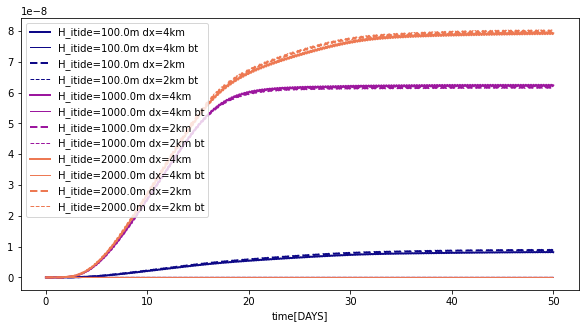

In [102]:
# quickly look at energies
fig, ax = plt.subplots(figsize=(10,5))

for r in R:
    _c = colors[r.depth_scale]
    _ls = ls[r.resolution]
    r.stats['KINETIC_ENRG'].plot(ax=ax, color=_c, ls=_ls, lw=2, label=r.label)
    r.stats['BTKIN_ENRG'].plot(ax=ax, lw=1., color=_c, ls=_ls, label=r.label+' bt')
    # ax.get_lines()[-1].get_color()
ax.legend()


---

## plot sections

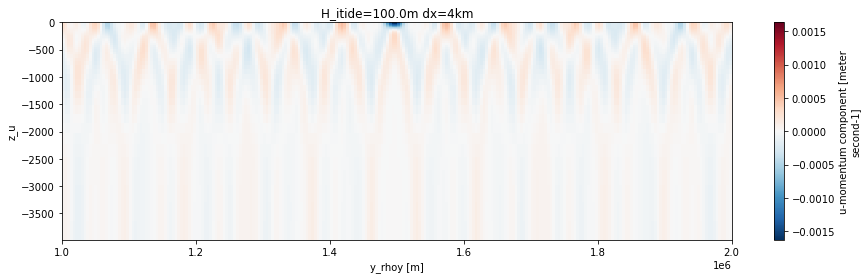

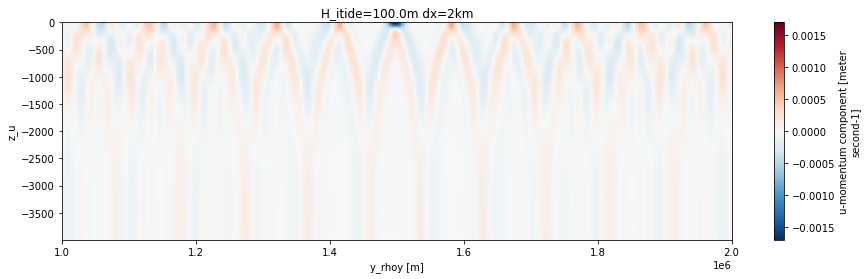

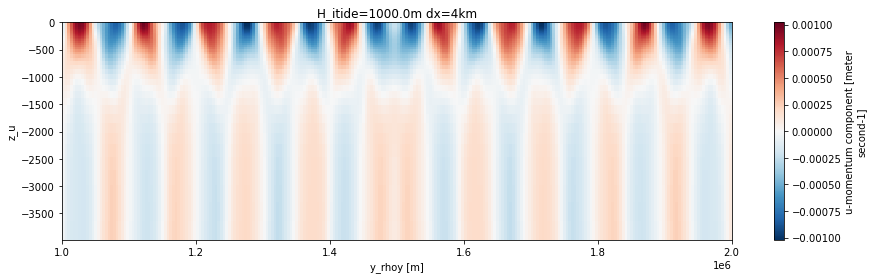

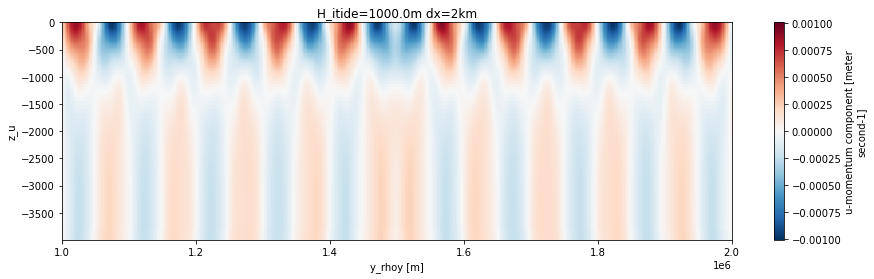

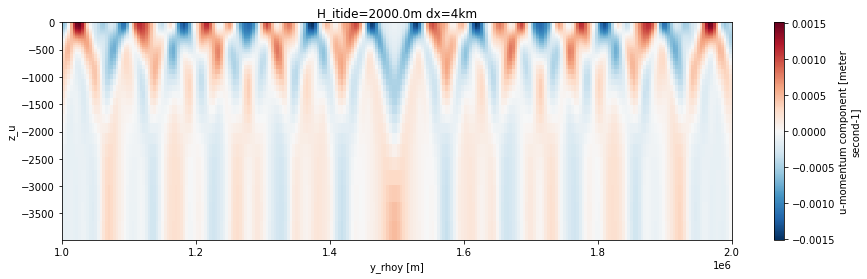

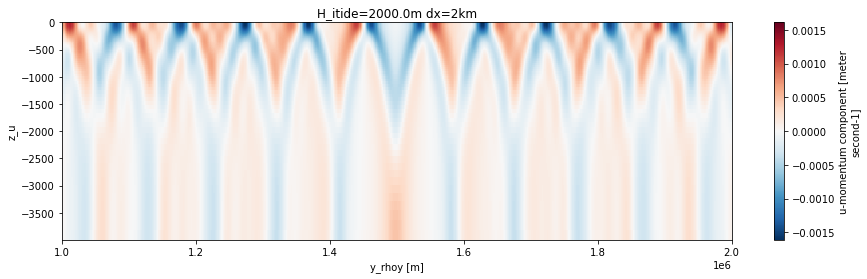

In [80]:
def plot_section(r,):
    
    ds = r["sec"]
    z_u = r.get_z(zeta=ds.ssh, h=ds.ssh*0+r["depth"])
    ds = ds.assign_coords(z_u = z_u)

    #time_slice = [5, 10, 50]
    time_slice = 50

    (ds.u
     .sel(time=time_slice)
     .plot(x='y_rho', y='z_u', 
           xlim=(1000*1e3,2000*1e3),
           #vmax=5*1e-4,
           figsize=(15,4),
           #figsize=(15,8),
           #col='time', col_wrap=1,
          ),
    )
    plt.title(r.label)
    
for r in R:
    plot_section(r)

---

## process data

1. compute modes
2. project velocity

In [115]:
def compute_vmodes(r):
    
    ds = r["sec"]
    
    # time dependent vertical grid
    h = r["grid"]["h"].isel(x_rho=0)
    ds = ds.assign_coords(h=h)
    ds = ds.assign_coords(z_r = r.get_z(zeta=ds["ssh"], h=h, vgrid="r"),
                          z_w = r.get_z(zeta=ds["ssh"], h=h, vgrid="w"),
                         )
    r["sec"] = ds.persist()
    
    # spatial and temporal mean stratification
    dsm = (ds
          .mean(dim=["time","y_rho"])
          .persist()
         )

    h = r["grid"]["h"].isel(x_rho=0, y_rho=0)

    zm_r = r.get_z(zeta=dsm.ssh, h=h)
    zm_w = r.get_z(zeta=dsm.ssh, h=h, vgrid='w')

    # interpolate first and the compute modes
    rho = ds["T"].rename('rho')
    rho_i = op.interp2z(zm_r, ds.z_r, rho) # time dependent on mean grid
    rho_m = rho_i.mean(["y_rho","time"])

    N2 = r.get_N2(rho_m, zm_r)
    
    r.vm = vmd.Vmodes(r['xgrid'], zm_r, zm_w, N2, 10, persist=True)
    
for r in R:
    compute_vmodes(r)

In [118]:
def process_run(r):

    ds = r["sec"]
    un = r.vm.project(ds["u"], "p", z=ds.z_r) #.persist()
    
    #y = 2000e3 # all mode arrive up to here (see diagnostic below)
    un_std = (un
              #.sel(y_rho=y, method="nearest")
              .rolling(time=24, center=True)
              .std()
              .isel(time=slice(0,None, 24))
              .dropna("time")
              .persist()
             )
    
    return un_std

P = [process_run(r) for r in R]

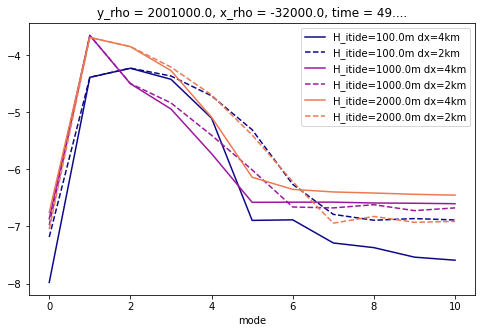

In [120]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
for r, p in zip(R, P):
    
    _c = colors[r.depth_scale]
    _ls = ls[r.resolution]
    
    y = 2000e3
    _p = p.sel(y_rho=y, method="nearest")
    np.log10(_p.isel(time=-1)).plot(ax=ax, color=_c, ls=_ls, label=r.label)

ax.legend()

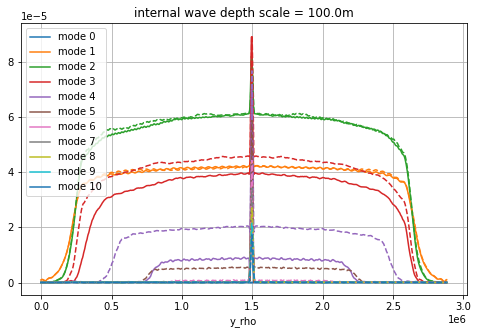

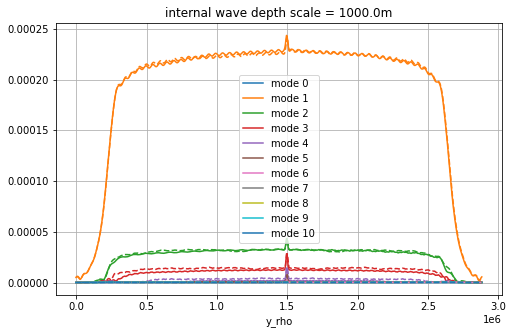

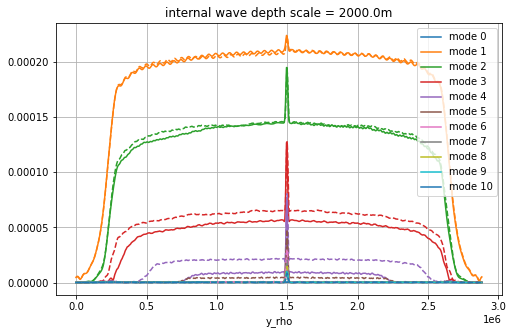

In [121]:
mode_max = 6

for d in depth_scales:
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    for r, p in zip(R, P):
        if r.depth_scale==d:
            _ls = ls[r.resolution]
            for m in p.mode:
                _p = p.isel(time=-1).sel(mode=m)
                label = ""
                if r.resolution==4:
                    label = "mode {}".format(int(m))
                _p.plot(ax=ax, ls=_ls, hue="mode", add_legend=False, label=label)
            plt.gca().set_prop_cycle(None)
    ax.set_title("internal wave depth scale = {}m".format(d))
    ax.grid()
    ax.legend()

--- 
## project various forcing shapes on vertical modes

In [122]:
vm = R[-1].vm

In [137]:
H = [100, 1000, 2000]
H = depth_scales

fun = lambda z, h: np.exp(- z**2/ h**2)

z = vm.ds.z_rho
profiles = (xr.concat([vm.project(fun(z, h)) for h in H], dim="depth_scale")
            .assign_coords(depth_scale=H)
           )

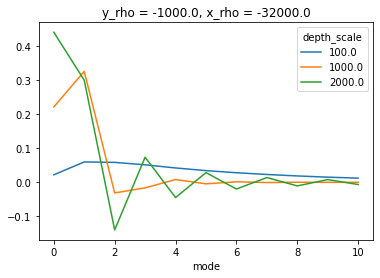

In [139]:
profiles.plot(x="mode", hue="depth_scale")

### Gaussian profile

In [180]:
H = np.arange(100, 4e3, 100)

fun = lambda z, h: np.exp(- z**2/ h**2)

z = vm.ds.z_rho
profiles = (xr.concat([vm.project(fun(z, h)) for h in H], dim="depth_scale")
            .assign_coords(depth_scale=H)
           )

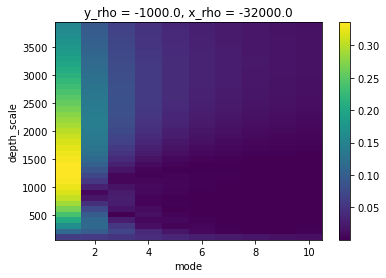

In [181]:
toplt = abs(profiles.isel(mode=slice(1,None)))
#toplt = toplt / toplt.sel(mode=1)
toplt.plot()
#np.log10(toplt).plot()

### mixed Gaussian modal profile

In [182]:
#H = np.arange(100, 4e3, 100)

fun = lambda z, h: np.exp(- z**2/ h**2)*vm.ds["phi"].sel(mode=1)
#fun = lambda z, h: np.exp(- abs(z)/ h)*vm.ds["phi"].sel(mode=1)

z = vm.ds.z_rho
profiles = (xr.concat([vm.project(fun(z, h)) for h in H], dim="depth_scale")
            .assign_coords(depth_scale=H)
           )

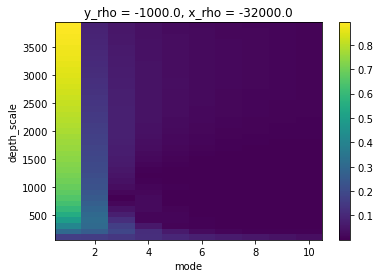

In [183]:
toplt = abs(profiles.isel(mode=slice(1,None)))
#toplt = toplt / toplt.sel(mode=1)
#toplt = np.log10(toplt)
toplt.plot()

## project

Wavelength:

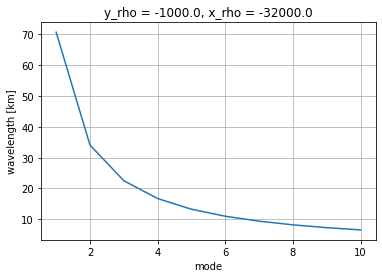

In [20]:
T = 2*np.pi/pout["itide_omega"]
fig, ax = plt.subplots(1,1)
(T*vm["c"][1:]/1e3).rename("wavelength [km]").plot(ax=ax)
ax.grid()

Travel time to exit domain:

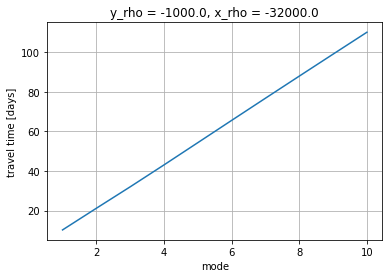

In [21]:
L = float(ds["y_rho"].max())
fig, ax = plt.subplots(1,1)
(L/2/vm["c"][1:]/86400).rename("travel time [days]").plot(ax=ax)
ax.grid()

In [35]:
un = vm.project(ds["u"], "p", z=z_r).persist()

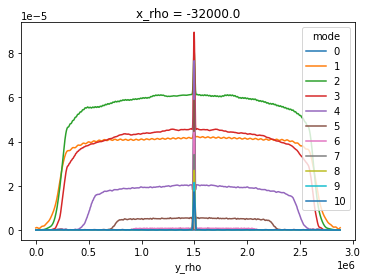

In [38]:
un.sel(time=slice(49,50))[1:].std("time").plot(hue="mode")

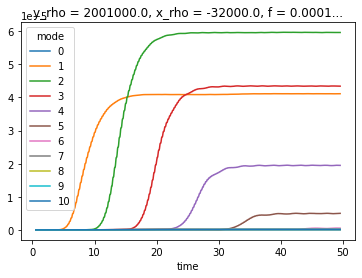

In [39]:
y = 2000e3 # all mode arrive up to here (see diagnostic below)
un_std = un.sel(y_rho=y, method="nearest").rolling(time=24, center=True).std().dropna("time")
un_std.plot(hue="mode")

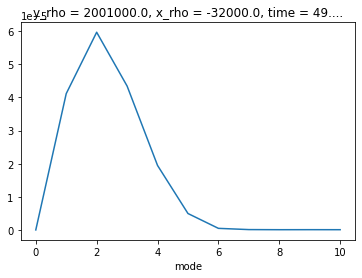

In [40]:
un_std.isel(time=-1).plot()

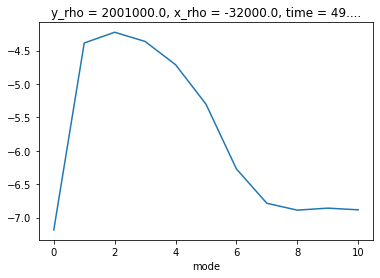

In [41]:
np.log10(un_std.isel(time=-1)).plot()

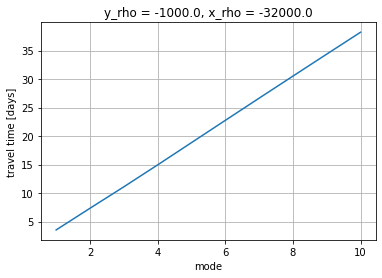

In [42]:
L = (y - pout["itide_y"])

fig, ax = plt.subplots(1,1)
(L/vm["c"][1:]/86400).rename("travel time [days]").plot(ax=ax)
ax.grid()

In [ ]:
def process(r):
    

---

## pressure

In [99]:
# compute pressure on rho grid
p = r.get_p(rho_i - rho_m, zm_w, zr=zm_r)
# should try to use true ROMS integration

# project
pn = vm.project(p, "p")

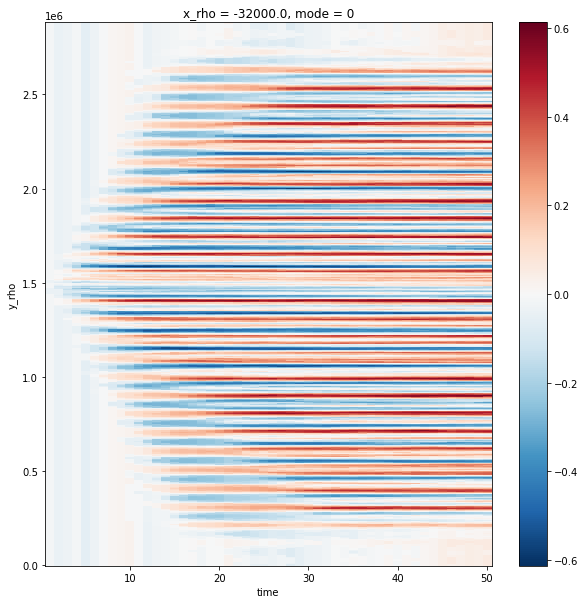

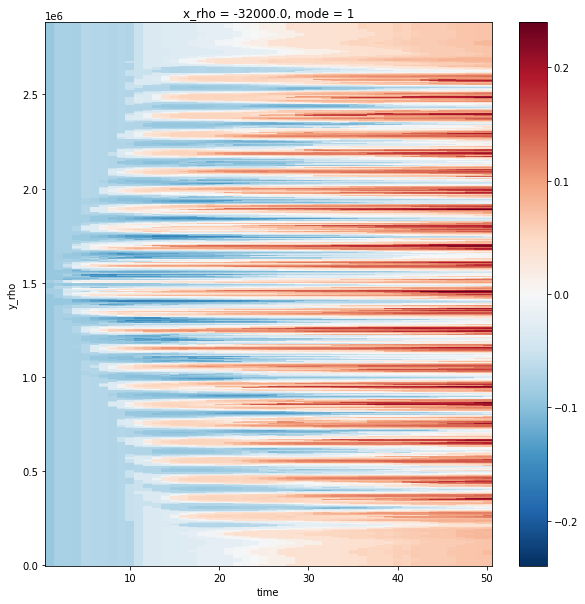

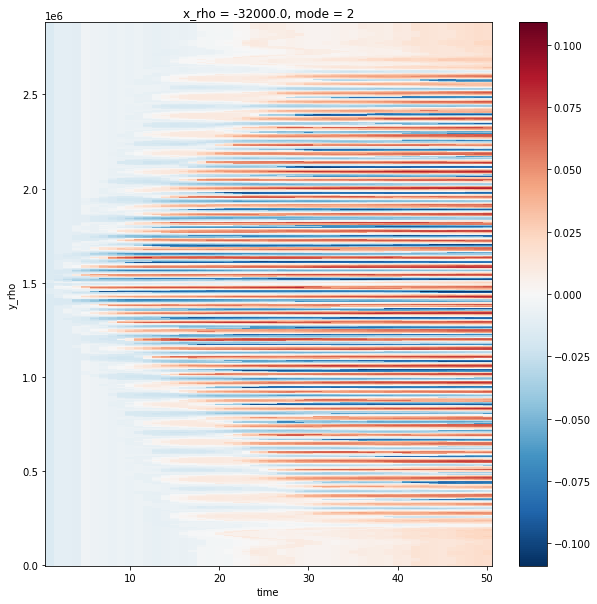

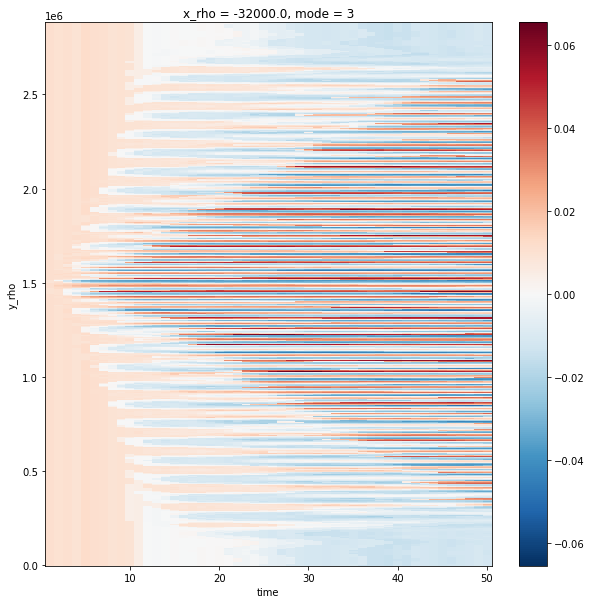

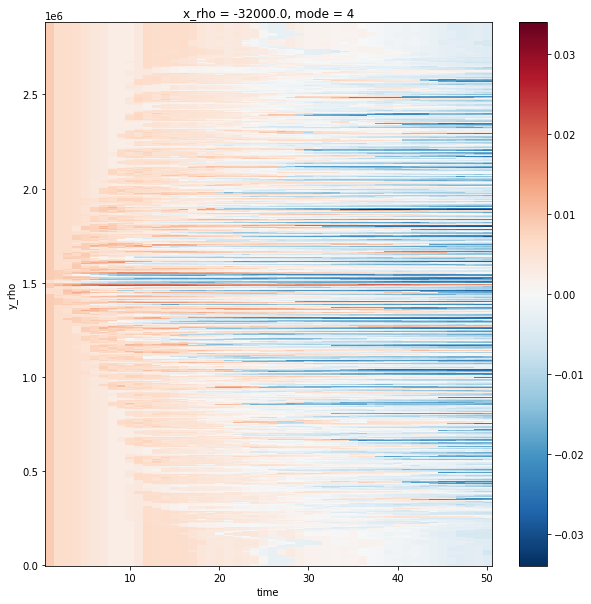

In [101]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    _pn = pn.sel(mode=m)
    #_pn = _pn - _pn.mean("y_rho")
    _pn.plot(ax=ax, x="time", y="y_rho")

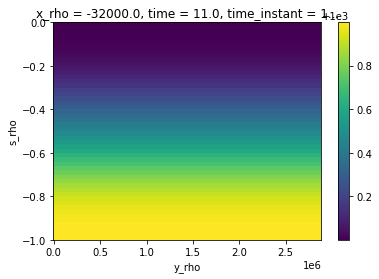

In [102]:
rho_i.isel(time=10).plot(x="y_rho")

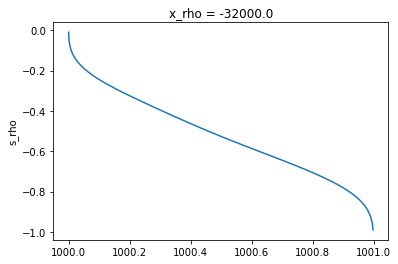

In [103]:
rho_m.plot(y="s_rho")

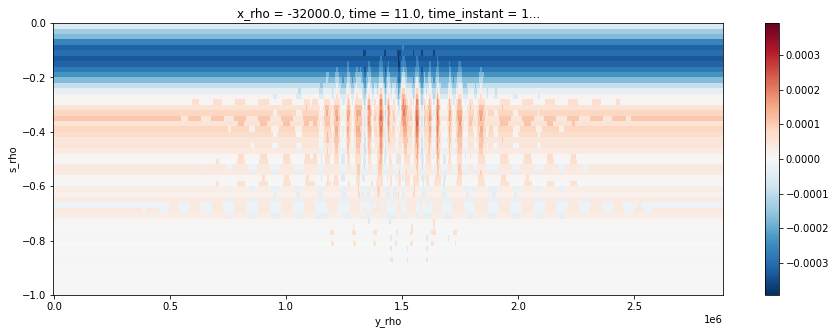

In [83]:
(rho_i - rho_i_mean).isel(time=10).plot(x="y_rho", figsize=(15,5))

In [ ]:
rho = ds["T"].rename('rho')
rho_i = op.interp2z(vm['z_rho'], z_r, rho)

rho_i_mean = rho_i.mean ...

p_i = get_p(vm["z_rho"], rho_i - rho_i_mean)

In [20]:
rho = ds["T"].rename('rho') + r["rho0"]

# compute pressure on rho grid
p_rho = r.get_p(rho, z_w, zr=z_r)

def get_p(grid, rho, zw):
    g = 9.81
    dz = grid.diff(zw, "s")
    p = grid.cumsum(rho*dz, "s", to="outer", boundary="extend")
    #p = grid.cumint(rho, "s", to="outer", boundary="extend")    
    return g*p.rename("p")

# compute pressure on w grid
#p = r.get_p(rho, z_w)
#p = get_p(r.xgrid, rho, z_w)

p = p_rho

# interpolates on mode vertical grid

In [54]:
#p = ds.P
#p = op.interp2z(vm['z_rho'], z_r, p_rho)
p = op.interp2z(vm['z_rho'], z_r, ds.P)

#p = op.interp2z(vm["z_rho"], z_w, p)

p_mean = p.sel(y_rho=slice(.5*1e6, 2.5*1e6)).mean(["y_rho","time"])

In [55]:
9.81*1000*4000

39240000.0

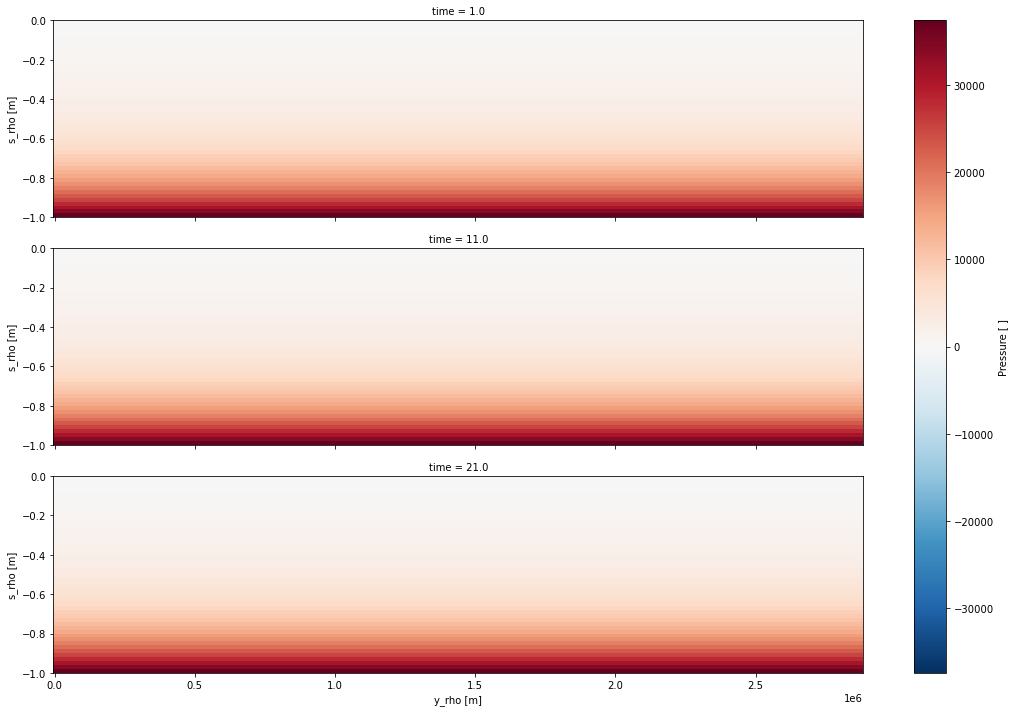

In [56]:
ds.P.isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

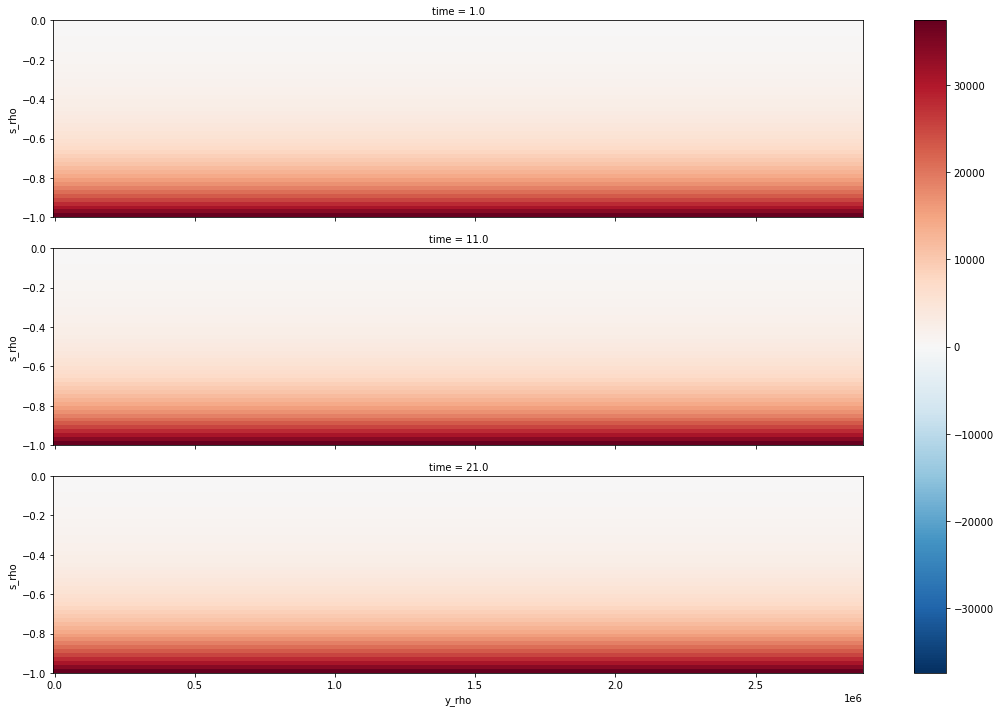

In [57]:
p.isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

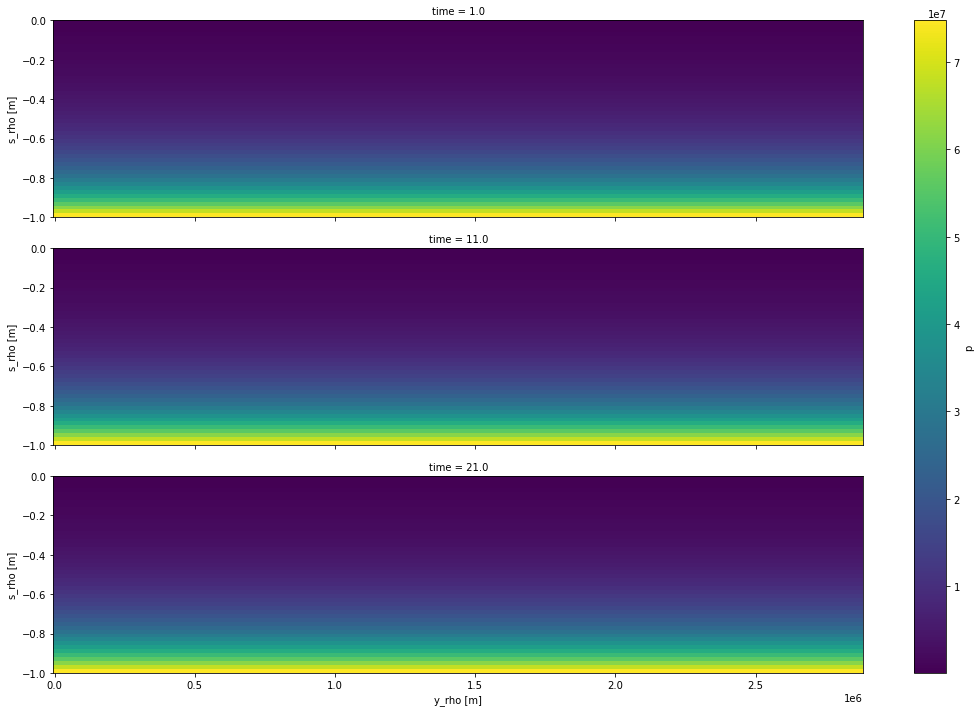

In [22]:
p_rho.isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

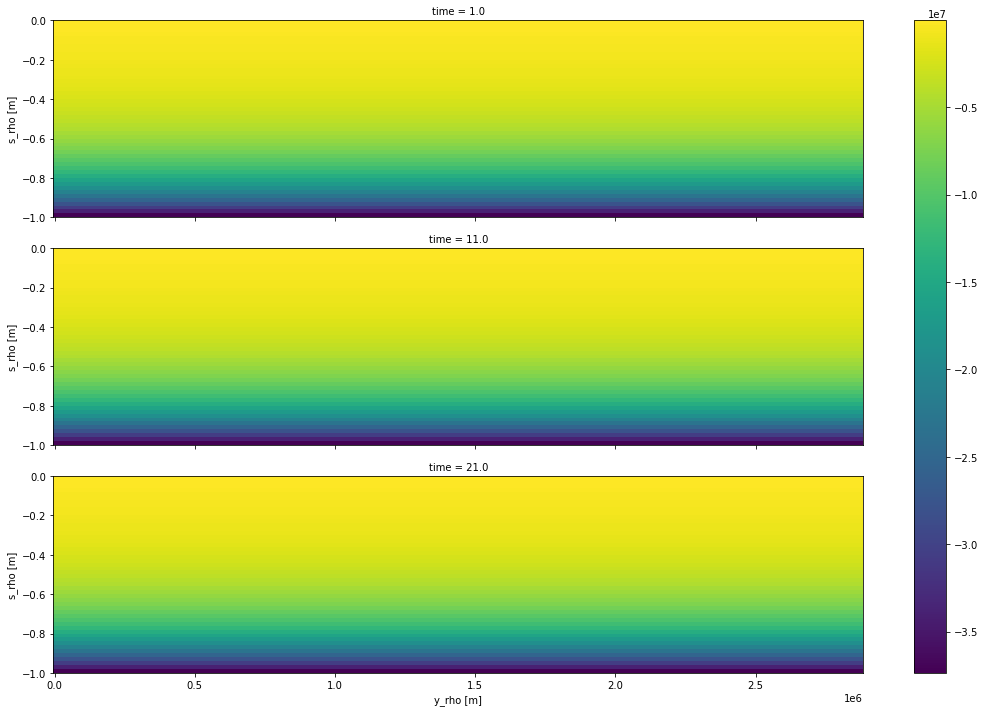

In [23]:
(ds.P*1e3-p_rho).isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

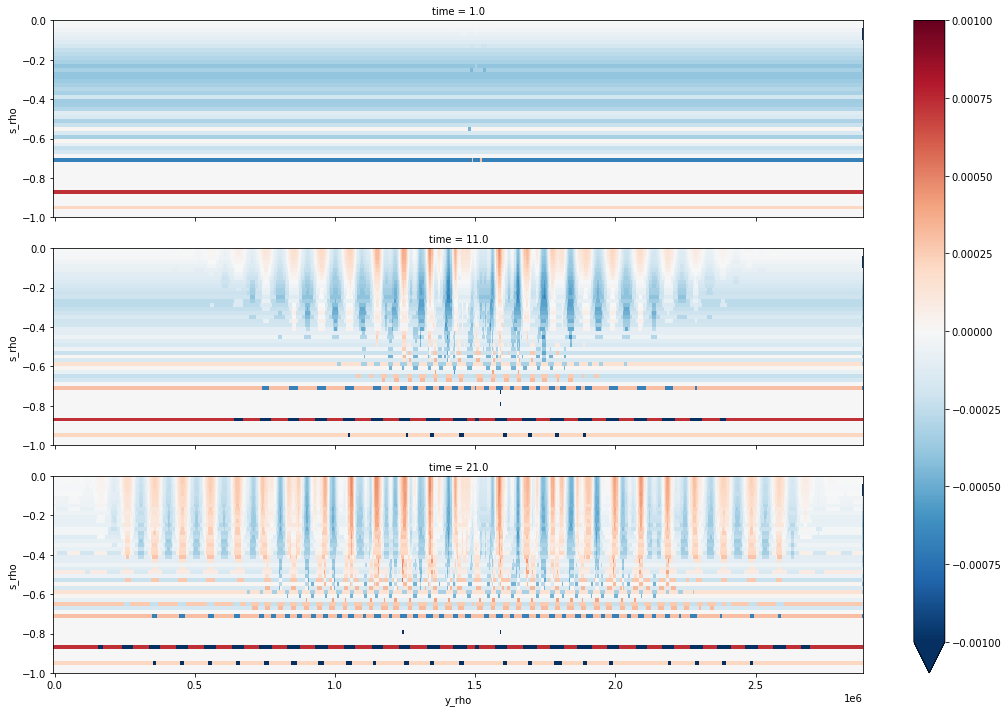

In [58]:
(p-p_mean).isel(time=slice(0,30,10)).plot(x="y_rho", col="time", vmax=.001, col_wrap=1, figsize=(15,10))

In [85]:
# project, data is already on vmode vertical grid
#pn = vm.project(p - p_mean, "p")
pn = vm.project(p_rho, "p")
# abs(ds_depth['z_rho'] - vmodes['z_rho']).max().compute() # 0

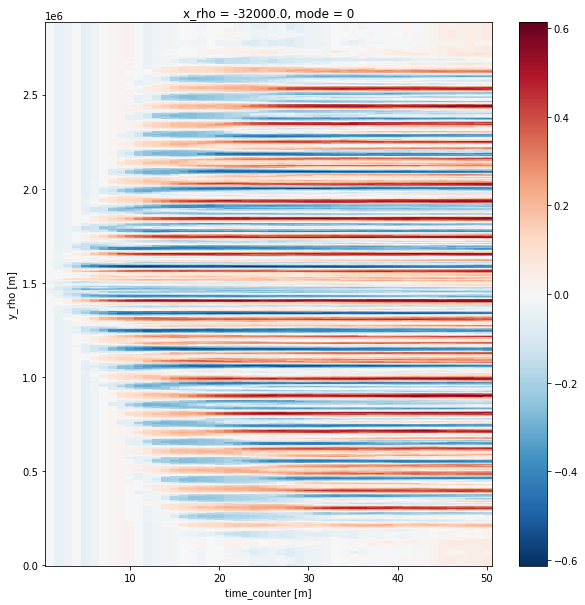

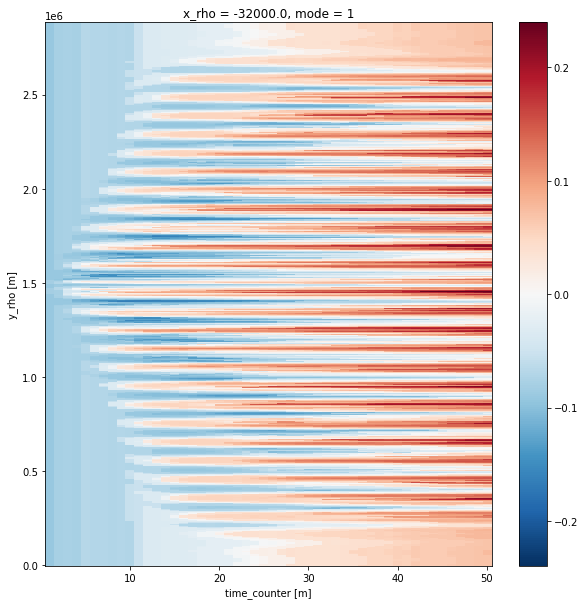

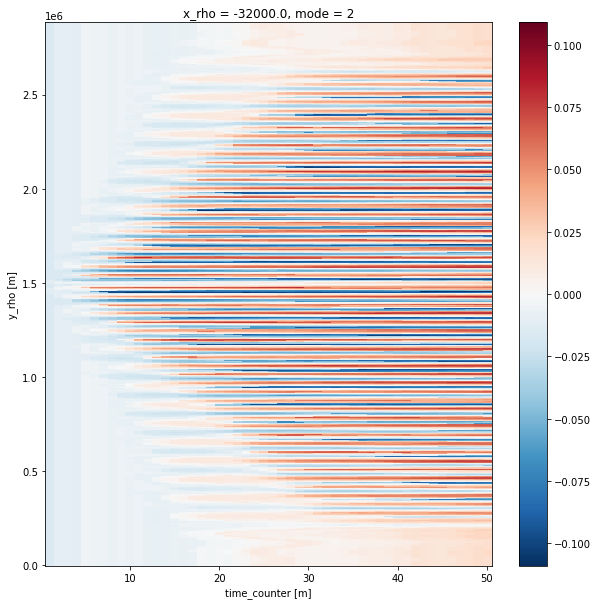

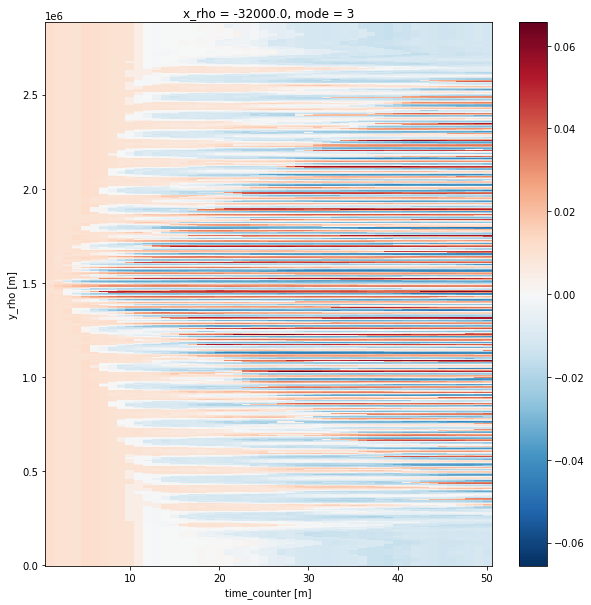

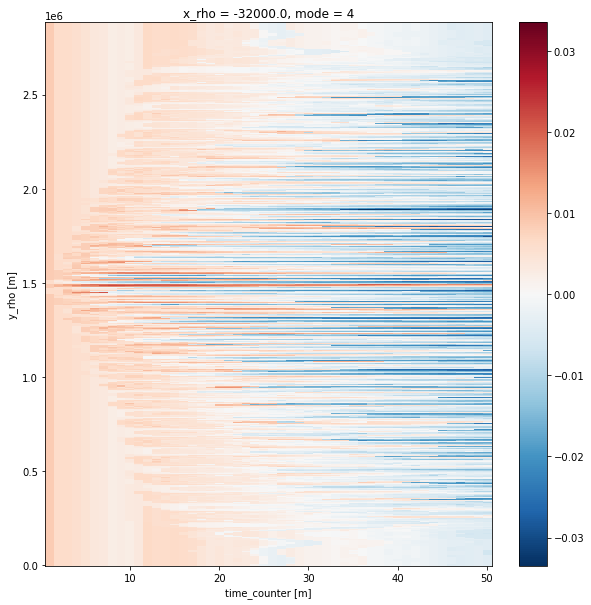

In [88]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    pn.sel(mode=m).plot(ax=ax, x="time", y="y_rho")

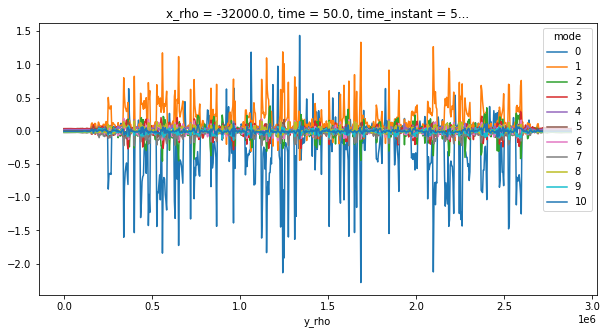

In [17]:
pn.isel(time=-1).plot(x="y_rho", hue="mode", figsize=(10,5))

---

In [43]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 